## Implementación de métricas de evaluación de IR

In [1]:
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from typing import List, Dict, Tuple

### Precision

Se define como la proporción de documentos recuperados (RET) que son relevantes (REL).

$\mathcal{P} = \frac{|\text{RET} \: \cap \: \text{REL}|}{|\text{RET}|}$

In [2]:
def precision(relevance_query: List[int]):
    assert set(relevance_query).issubset((0, 1)), "Only binary values (0, 1) allowed."

    return sum(relevance_query) / len(relevance_query)

In [3]:
precision([0, 0, 0, 1])

0.25

### Precision at K

Se define como la proporción de documentos top-K recuperados que son relevantes.

In [4]:
def precision_at_k(relevance_query: List[int], k: int):
    assert set(relevance_query).issubset((0, 1)), "Only binary values (0, 1) allowed."
    assert k > 0, "K must be greater or equal than 1."

    return sum(relevance_query[:k]) / len(relevance_query[:k])

In [5]:
precision_at_k([0, 0, 0, 1], 1)

0.0

### Recall at K

Se define como la proporción de documentos relevantes que se recuperan en el top K.

In [6]:
def recall_at_k(relevance_query: List[int], k: int, num_relevant_docs: int):
    assert set(relevance_query).issubset((0, 1)), "Only binary values (0, 1) allowed."
    assert k > 0, "K must be greater or equal than 1."
    assert num_relevant_docs > 0, "Number of relevant docs must be greater or equal than 1."

    return sum(relevance_query[:k]) / num_relevant_docs

In [7]:
recall_at_k([0, 0, 0, 1], 1, 4)

0.0

### Average precision

Se define como el promedio de los **Precision at K**, calculados de manera iterativa al aumentar iterativamente **K** cada vez que se encuentra un documento relevante. El cálculo se detiene cuando se obtiene un **recall** de 1.

In [8]:
def average_precision(relevance_query: List[int]):
    assert set(relevance_query).issubset((0, 1)), "Only binary values (0, 1) allowed."

    cumulative_precision = 0
    relevant_count = 0

    for observation_count, relevance in enumerate(relevance_query, 1):
        if relevance:
            relevant_count += 1
            cumulative_precision += relevant_count / observation_count

    return cumulative_precision / relevant_count

In [9]:
average_precision([0, 1, 0, 1, 1, 1, 1])

0.5961904761904762

### Mean Average Precision (MAP)

Promedio de calcular el **Average Precision** para varias consultas.

In [10]:
def mean_average_precision(relevance_queries: List[List[int]]):
    assert all(set(sublist).issubset((0, 1)) for sublist in
               relevance_queries), "Only binary values (0, 1) allowed in all query results."

    return sum(average_precision(relevance_query) for relevance_query in relevance_queries) / len(relevance_queries)

In [11]:
mean_average_precision([[1, 0, 1], [0, 1, 1]])

0.7083333333333333

### Discounted Cumulative Gain at K

Sea $\text{REL}_i$ la relevancia asociada con el documento en el rango $i$, $1 \leq i \leq K$. Definimos:

$\text{DGG@K} = \sum_{i = 1}^{K} \frac{\text{REL}_i}{\log_2 (\max (i,\: 2))}$

In [12]:
def discounted_cumulative_gain(relevance_query: List[int], k: int):
    assert all(x >= 0 for x in relevance_query), "All elements must be integers greater than or equal to 0."
    assert k > 0, "K must be greater or equal than 1."

    return sum(relevance / np.log2(max(i, 2)) for i, relevance in enumerate(relevance_query[:k], 1))

In [13]:
discounted_cumulative_gain([4, 4, 3, 0, 0, 1, 3, 3, 3, 0], 6)

10.279642067948915

### Normalized Discounted Cumulative Gain at K

Dada la DGG@K de una consulta, se divide entre el mejor DGG@K posible para esa consulta.

In [14]:
def normalized_discounted_cumulative_gain(relevance_query: List[int], k: int):
    assert all(x >= 0 for x in relevance_query), "All elements must be integers greater than or equal to 0."
    assert k > 0, "K must be greater or equal than 1."

    rq = relevance_query.copy()
    rq.sort(reverse=True)
    return discounted_cumulative_gain(relevance_query, k) / discounted_cumulative_gain(rq, k)

In [15]:
normalized_discounted_cumulative_gain([4, 4, 3, 0, 0, 1, 3, 3, 3, 0], 6)

0.7424602308163405

## Query evaluation


A continuación vamos a usar las funciones definidas para evaluar el conjunto de queries, con sus consultas realizadas con nuestra implementación de RRDV y con Gensim.

Primero especifiquemos las rutas donde se encuentran los resultados y los datos de evaluación revisados por expertos.

In [16]:
expert_results_path = 'data/relevance-judgments.tsv'
rrdv_results_path = 'data/RRDV-consultas_resultados'
gensim_results_path = 'data/GESIM-consultas_resultados'

In [17]:
# Función para leer los resultados de búsqueda desde un archivo
def read_query_search_file(result_path: Path) -> Dict[str, Dict[str, float]]:
    """
    Lee un archivo de resultados de búsqueda y los estructura en un diccionario.
    
    Parámetros:
    - result_path (Path): Ruta al archivo con los resultados de búsqueda.

    Retorno:
    - results (Dict[str, Dict[str, float]]): Un diccionario donde las llaves son los nombres de las consultas y los valores son diccionarios de documentos con su relevancia asociada.
    """
    results = {}

    with open(result_path, "r") as f_expert:
        for line in f_expert:
            # Para cada línea separamos el identificador del query de sus documentos relevantes.
            query_name, query_results_text = line.strip().split('\t')
            query_results = {}

            # Organizamos cada documento relevante en un diccionario, donde la llave es su identificador y su valor es su relevancia.
            for result_text in query_results_text.split(','):
                doc_name, relevance = result_text.split(':')
                query_results[doc_name] = float(relevance)

            # Estos documentos se asocian al query.
            results[query_name] = query_results

    return results

# Función para graficar la distribución de una métrica.
def plot_distribution(values: List[float], variable_name: str) -> None:
    """
    Grafica la distribución de una métrica.

    Parámetros:
    - values (List[float]): Lista de valores de la métrica a graficar.
    - variable_name (str): Nombre de la variable para el título y etiquetas del gráfico.
    """
    sns.histplot(values, bins=30, kde=True)
    plt.title(f'Distribution of {variable_name}')
    plt.xlabel(variable_name)
    plt.ylabel('Frequency')
    plt.show()

# Función para evaluar las métricas de la consulta
def query_evaluation_metrics(expert_result_path: Path, model_result_path: Path) -> None:
    """
    Compara los resultados de la recuperación del modelo con los resultados expertos y calcula métricas de evaluación.

    Parámetros:
    - expert_result_path (Path): Ruta al archivo de resultados expertos.
    - model_result_path (Path): Ruta al archivo de resultados del modelo.
    """

    # Lee los resultados tanto del experto como del modelo.
    expert_results = read_query_search_file(expert_result_path)
    model_results = read_query_search_file(model_result_path)
    
    # Creación de listas para calcular métricas.
    ms, P_m, R_m, nDCG_m, binary_queries = [], [], [], [], []
    
    # Iteramos sobre cada query.
    for query in model_results:
        if query in expert_results:

            # Extraemos los documentos recuperados por el modelo, y aquellos relevantes según los expertos.
            query_expert_relevant_documents = expert_results[query]
            query_model_relevant_documents = model_results[query]
            
            # M en este caso es la longitud de los documentos que sí son relevantes
            m = len(query_expert_relevant_documents)

            # Para la relevancia binaria vamos a tomar simplemente 1 si el documento recuperado es relevante, 0 de lo contrario.
            binary_relevance_query = [int(doc in query_expert_relevant_documents) for doc in query_model_relevant_documents]
            # La relevancia no binaria ya viene dada como un entero en los documentos revisados por los expertos.
            gain_relevance_query = [query_expert_relevant_documents.get(doc, 0) for doc in query_model_relevant_documents]
            
            # Calculamos y vamos agregando al listado el resultado de cada métrica para cada query.
            ms.append(m)
            P_m.append(precision_at_k(binary_relevance_query, m))
            R_m.append(recall_at_k(binary_relevance_query, m, len(query_expert_relevant_documents)))
            nDCG_m.append(normalized_discounted_cumulative_gain(gain_relevance_query, m))
            binary_queries.append(binary_relevance_query)
    
    # Imprimimos como métrica general el MAP, y graficamos la distribución de cada una de las métricas.
    print("MAP: ",mean_average_precision(binary_queries))
    plot_distribution(ms, 'number of relevant documents (M)')
    plot_distribution(P_m, 'Precision at M (P@M)')
    plot_distribution(R_m, 'Recall at M (R@M)')
    plot_distribution(nDCG_m, 'Normalized Discounted Cumulative Gain at M (nDCG@M)')

En el caso de que no tengamos los resultados de nuestro modelo de RRDV y el de Gensim, ejecutamos los notebooks que los generan.

In [18]:
%run ranked_recovery.ipynb
%run gensim_search.ipynb

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


A continuación, los resultados para nuestro modelo de RRDV:

MAP:  0.7476806265561247


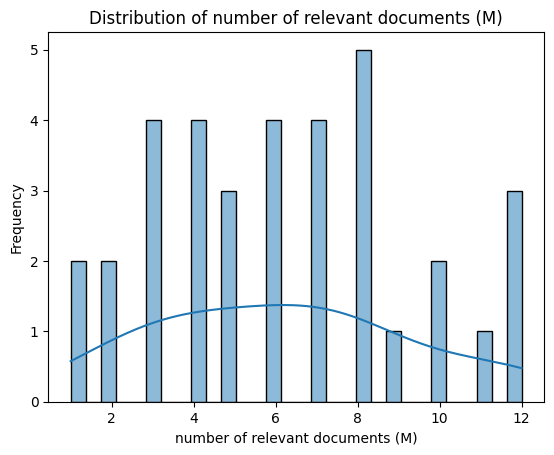

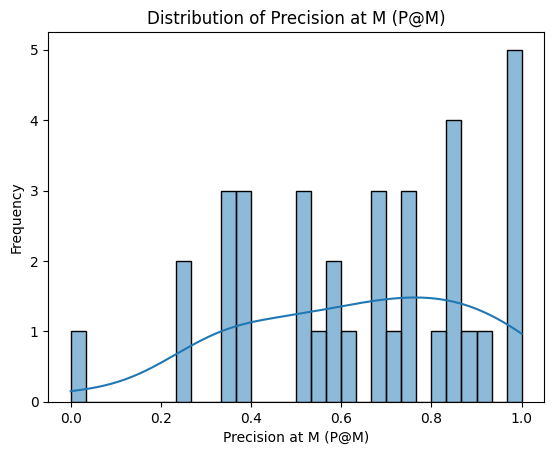

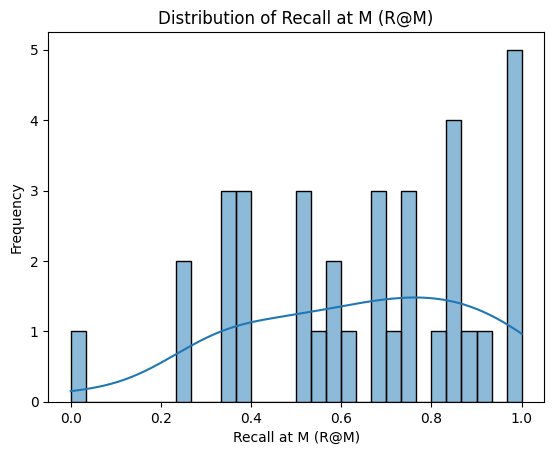

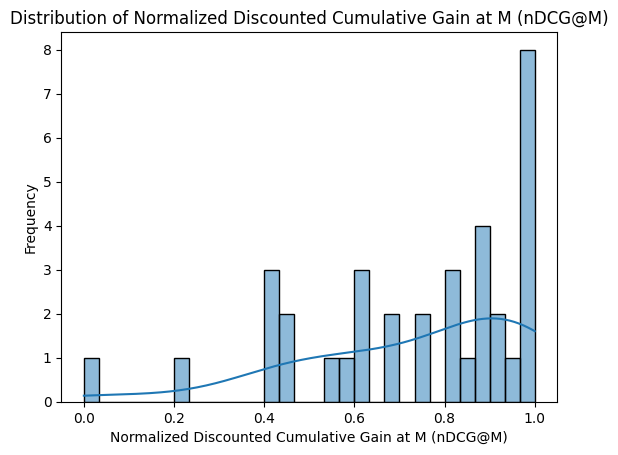

In [19]:
query_evaluation_metrics(expert_results_path, rrdv_results_path)

Y el del modelo construido con Gensim:

MAP:  0.7041615877565259


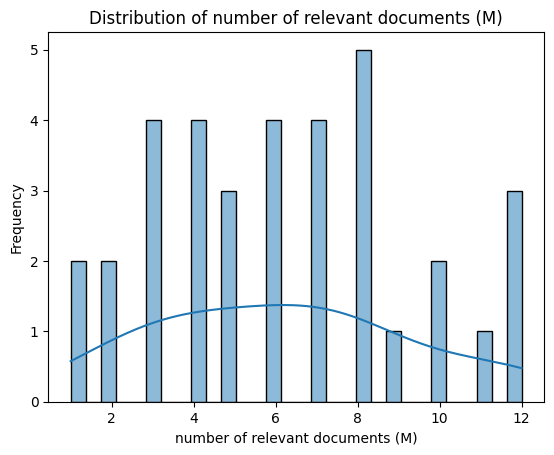

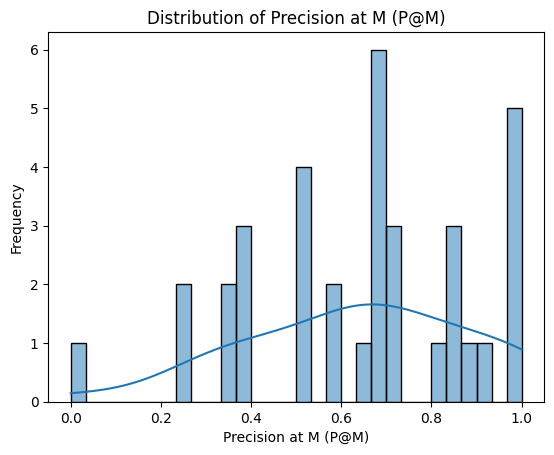

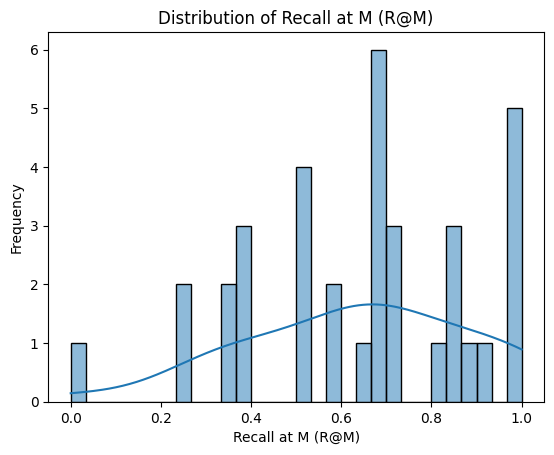

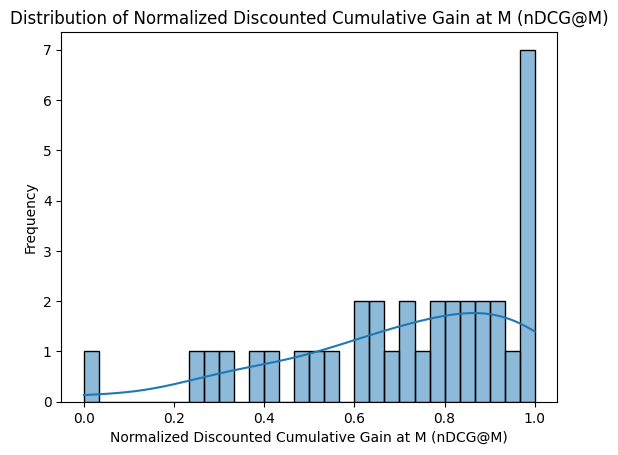

In [20]:
query_evaluation_metrics(expert_results_path, gensim_results_path)